In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


In [2]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성

In [11]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_answer_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        print("yes")
        return "relevant"
    else:
        print("no")
        return "not relevant"

### 검색 노드 추가

In [5]:
from langchain_teddynote.tools.tavily import TavilySearch

# # 검색 도구 생성
# tavily_tool = TavilySearch()

# search_query = "2024년 노벨 문학상 수상자는?"

# # 다양한 파라미터를 사용한 검색 예제
# search_result = tavily_tool.search(
#     query=search_query,  # 검색 쿼리
#     max_results=3,  # 최대 검색 결과
#     format_output=True,  # 결과 포맷팅
# )

# # 검색 결과 출력
# print(search_result)

TavilySearch를 사용해서 state의 question값에 대한 검색을 하고 나온 값을 {context: search_result}의 딕셔너리 형식으로 보냄

In [12]:
# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=6,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return {"context": search_result}

### edge 추가

relevance_check에서 관련성체크를 하고 관련성이 있다면 llm_answer, 없다면 web_search로 넘어감.

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# Web Search 노드 추가
workflow.add_node("web_search", web_search)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "relevant": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "not relevant": "web_search",  # 관련성이 없으면 웹 검색을 수행합니다.
    },
)

workflow.add_edge("web_search", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

### 그래프 시각화

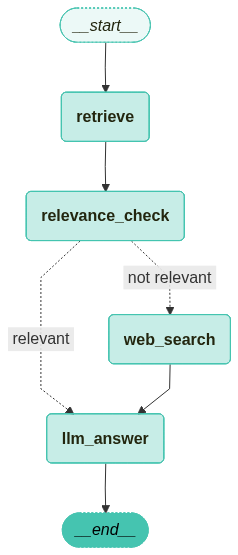

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

### 그래프 실행

리스트 안에 relevance_check, llm_answer를 넣었기 때문에 체크하는부분과 최종 답변만 출력됨.
만약 web_search를 포함시키면 웹에서 검색되는 부분이 포함됨.

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# llm이 자체 대답하기 힘든 질문 - web_search
inputs = GraphState(question="2024년 노벨 문학상 수상자는?")

# 그래프 실행
invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])

==== [RELEVANCE CHECK] ====
no
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
2024년 노벨 문학상 수상자는 한국 작가 한강입니다. 

**Source**
- https://overseas.mofa.go.kr/se-ko/brd/m_7977/view.do?seq=1345639
- https://www.hani.co.kr/arti/culture/culture_general/1161999.html
- https://www.youtube.com/watch?v=FsMuWl5LYNA
('user', '2024년 노벨 문학상 수상자는?')
('assistant', '2024년 노벨 문학상 수상자는 한국 작가 한강입니다. \n\n**Source**\n- https://overseas.mofa.go.kr/se-ko/brd/m_7977/view.do?seq=1345639\n- https://www.hani.co.kr/arti/culture/culture_general/1161999.html\n- https://www.youtube.com/watch?v=FsMuWl5LYNA')


In [18]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# llm이 자체 대답하기 힘든 질문 - web_search
inputs = GraphState(question="2024년 노벨 문학상 수상자는?")

# 그래프 실행
invoke_graph(app, inputs, config, ["relevance_check", "web_search","llm_answer"])

==== [RELEVANCE CHECK] ====
no
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<document><title>한국 작가 한강, 2024년 노벨 문학상 수상 상세보기|공지사항</title><url>https://overseas.mofa.go.kr/se-ko/brd/m_7977/view.do?seq=1345639</url><content>**바로가기 메뉴** 본문 바로가기 주메뉴 바로가기 * 대사관 활동 ## 한국 작가 한강, 2024년 노벨 문학상 수상 :   주 스웨덴 대사관 스웨덴 한림원은 10.10(목) 2024년 노벨 문학상 수상자로 한국 작가 한강을 선정했습니다. 한국인 최초 노벨문학상 수상이자 아시아 여성 작가로서 최초 수상이라는 의미가 있으며, 금번 수상을 통해 한국 문학의 독창성과 깊이가 전세계적으로 인정받고 각인시키는 계기가 될 것으로 기대합니다. 한강 작가가 초청되었던 금년 3월 스웨덴 스톨혹름 북콘서트와 우메오 국제문학축제에서는 한강 작가의 최신작 ‘작별하지 않는다’에 대한 스웨덴 문학애호가들의 높은 관심과 애정을 확인할 수 있었습니다. 한국 문화 전반에 대한 전세계적인 열풍 속에서 북유럽 지역에서도 한국 음식, 드라마, 뷰티, 대중가요 등 K-콘텐츠에 대한 인기가 높아지고 있습니다. 한강 작가의 노벨문학상 수상을 계기로 한국 문학이 북유럽과 전세계로 뻗어나갈 수 있도록 우리 대사관과 문화원 또한 노력하겠습니다. 주스웨덴 대한민국 대사관</content><raw>**바로가기 메뉴**
[본문 바로가기](#contents)
[주메뉴 바로가기](#gnb)





**알림·소식**

* [공지사항](/se-ko/brd/m_7977/list.do "현재 페이지")
* [다가오는